##  Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, 
проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. 
Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 Описание колонок
1. experimentVariant – вариант эксперимента
2. version – версия приложения
3. purchase – факт покупки
 
Задача
Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000).
Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента 
(# подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста
 

💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. 
Эту полезную информацию можно использовать для исследования проблемы:

1.  Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП.
2.  Возможно уже станет ясно где именно причины поломки
3.  Посчитайте pvalue для каждой версии МП
4.  Найдите версии, где pvalue < 0.05
5.  Исключите версию с pvalue > 0.05 из основного датафрейма
6.  Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
7.  Вы нашли поломку

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [10]:
df = pd.read_csv('hw_aa.csv', sep=';', index_col= 0) 
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


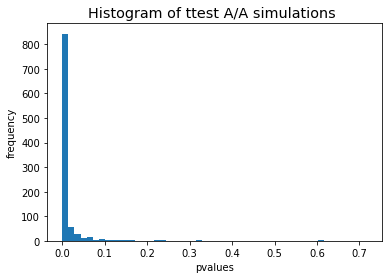

0.936

In [12]:
s1_ = df[df.experimentVariant == 1]['purchase']
s2_ = df[df.experimentVariant == 0]['purchase']

n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = s1_.sample(n_s, replace = False).values
    s2 = s2_.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В 93% случаев мы получаем стат.значимые различия! А сравниваемые группы должны быть одинаковыми! 

In [13]:
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [17]:
df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean', 'uid': 'count'})

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


уже видно, что в нулевой и перовой группах размер выборок по версии моб.приложения примерно одинаковый, но(!) 
в версии  v2.8.0 в нулевой группе средняя сумма покупки (конверсия) намного ниже, чем в перовой группе


Попробуем исключить версию v2.8.0 из эксперимента и снова расчитать FPR через A/A

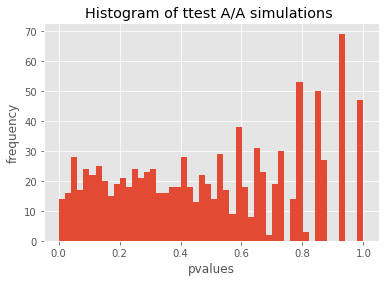

0.042

In [20]:
s1_ = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase']
s2_ = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase']

n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = s1_.sample(n_s, replace = False).values
    s2 = s2_.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

количество ложноположительных случаев не превышает альфа!

## Итого нашли поломку! Проблема была в версии v2.8.0 моб.приложения